In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_csv('train.csv')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
data.shape

(10000, 20)

Чистим данные

In [7]:
def drop_data(data):
    data = data.loc[data['Rooms'] < 10, :]
    data = data.loc[data['Price'].between(30000, 600000), :]
    return data


def clean_data(data):
    data.loc[(data['Square'] < 15) & (data['LifeSquare'] > 15), 'Square'] = data['LifeSquare']
    data.loc[(data.Square < 15) & (data.LifeSquare < 15) & (data.Rooms <= 1), 'Square'] =\
    data.loc[data.Rooms <= 1, 'Square'].mean()
    data.loc[(data.Square < 15) & (data.LifeSquare < 15) & (data.Rooms == 3), 'Square'] =\
    data.loc[data.Rooms == 1, 'Square'].mean()
    data.loc[(data['Square'] > 15) & (data['LifeSquare'] <15), 'LifeSquare'] = data['Square']
    data.loc[data['Square'] < data['LifeSquare'], 'LifeSquare'] = data['Square']
    data['LifeSquare'] = data['LifeSquare'].fillna(data['Square'])
    data.loc[data['Floor'] > data['HouseFloor'],'Floor'] = data['HouseFloor']
    data.loc[data['HouseFloor'] == 0, 'HouseFloor'] = int(data.loc[:, 'HouseFloor'].mean())
    data.loc[data['Floor'] == 0,'Floor'] = int(data.loc[:, 'Floor'].mean())
    return data
    

In [8]:
data = drop_data(data)
data = clean_data(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9977 entries, 0 to 9999
Data columns (total 20 columns):
Id               9977 non-null int64
DistrictId       9977 non-null int64
Rooms            9977 non-null float64
Square           9977 non-null float64
LifeSquare       9977 non-null float64
KitchenSquare    9977 non-null float64
Floor            9977 non-null float64
HouseFloor       9977 non-null float64
HouseYear        9977 non-null int64
Ecology_1        9977 non-null float64
Ecology_2        9977 non-null object
Ecology_3        9977 non-null object
Social_1         9977 non-null int64
Social_2         9977 non-null int64
Social_3         9977 non-null int64
Healthcare_1     5185 non-null float64
Helthcare_2      9977 non-null int64
Shops_1          9977 non-null int64
Shops_2          9977 non-null object
Price            9977 non-null float64
dtypes: float64(9), int64(8), object(3)
memory usage: 1.9+ MB


In [9]:
data = data.drop('Healthcare_1', axis=1)

"Оцифруем" категории

In [10]:
data = pd.get_dummies(data)

Средние показатели числовых признаков, за исключением некоторых, разнятся не значительно, нет необходимости в нормализации данных

In [11]:
data.mean()

Id                 8382.190538
DistrictId           50.355718
Rooms                 1.884534
Square               56.267666
LifeSquare           42.362675
KitchenSquare         6.266012
Floor                 7.890448
HouseFloor           12.930741
HouseYear          3994.773379
Ecology_1             0.118923
Social_1             24.673349
Social_2           5349.221910
Social_3              8.012028
Helthcare_2           1.316829
Shops_1               4.226521
Price            213336.700911
Ecology_2_A           0.009722
Ecology_2_B           0.990278
Ecology_3_A           0.027363
Ecology_3_B           0.972637
Shops_2_A             0.082690
Shops_2_B             0.917310
dtype: float64

Создадим дополнительный столбец для улучшения качества регрессии

In [12]:
data['Square_2'] = data.Square ** 2

Наличие таких признаков переводит линейную регрессию в разряд "псевдолинейных", но отдельно нелинейная регрессия у нас рассматриваться не будет.

Разобъем данные на train и valid

In [13]:
train, valid = train_test_split(data, test_size=0.3, random_state=13)

In [14]:
train.shape

(6983, 23)

In [15]:
valid.shape

(2994, 23)

Создадим дополнительный столбец со средними ценами по районам и комнатам для улучшения качества регрессии

In [16]:
def mean_costs_and_rooms(train, valid):
    train_mean_price = train.groupby(['DistrictId' ,'Rooms'])[['Price']].mean().reset_index()
    train_mean_price = train_mean_price.rename(columns={'Price':'mean_price'})
    train = pd.merge(train, train_mean_price, on=['DistrictId','Rooms'], how='left')
    valid = pd.merge(valid, train_mean_price, on=['DistrictId','Rooms'], how='left')
    
    train_room_price = train.groupby(['Rooms'])[['Price']].mean().reset_index().rename(columns={'Price':'rooms_price'})
    train = pd.merge(train, train_room_price, on=['Rooms'],how='left')
    valid = pd.merge(valid, train_room_price, on=['Rooms'],how='left')
    valid['mean_price'] = valid['mean_price'].fillna(valid['rooms_price'])
    return train, valid
    

In [17]:
train, valid = mean_costs_and_rooms(train, valid)

In [18]:
valid.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
       'Square_2', 'mean_price', 'rooms_price'],
      dtype='object')

In [19]:
valid['rooms_price'].isnull().sum()

0

In [20]:
valid['mean_price'].isnull().sum()

0

# Подберем модель линейной регрессии

In [21]:
fts = [ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1',  'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B', 'Square_2',
       'mean_price']

In [22]:
def linear_regression(train, valid, target_name, fts):
    lr = LinearRegression()
    lr.fit(train.loc[:, fts], train[target_name])
    pred = lr.predict(train.loc[:, fts])
    r2_train = r2(train[target_name], pred)
    pred_valid = lr.predict(valid.loc[:, fts])
    r2_valid = r2(valid[target_name], pred_valid)
    return [lr, r2_train, r2_valid]
    

In [23]:
lin_reg1 = linear_regression(train, valid, 'Price', fts)
print(f'r2_train = {lin_reg1[1]:.6f}')
print(f'r2_valid = {lin_reg1[2]:.6f}')

r2_train = 0.722638
r2_valid = 0.628529


In [24]:
coef ={}
for i in range(len(lin_reg1[0].coef_)):
    coef[str(fts[i])] = lin_reg1[0].coef_[i]
coef

{'Rooms': -30724.341374787204,
 'Square': 2822.9575917846028,
 'LifeSquare': -451.86069740425336,
 'KitchenSquare': -12.20014912141774,
 'Floor': 789.7539837599975,
 'HouseFloor': 622.7690617791228,
 'HouseYear': 0.0008444731640831538,
 'Ecology_1': -8369.284903790043,
 'Social_1': 848.827669715467,
 'Social_2': -2.1301843826663727,
 'Social_3': 136.52198357061303,
 'Helthcare_2': 1610.2113336280502,
 'Shops_1': -845.3167008429479,
 'Ecology_2_A': -1624.7762244487992,
 'Ecology_2_B': 1624.7762244488079,
 'Ecology_3_A': 587.6921217950863,
 'Ecology_3_B': -587.6921217950886,
 'Shops_2_A': -1353.0083985257195,
 'Shops_2_B': 1353.0083985257174,
 'Square_2': -3.786990298411552,
 'mean_price': 0.9226113879300182}

Посмотрим корреляцию признаков с целевым

In [25]:
correl = data.corr()
correl.Price

Id               0.009470
DistrictId       0.265229
Rooms            0.569079
Square           0.516133
LifeSquare       0.266377
KitchenSquare    0.028431
Floor            0.114469
HouseFloor       0.088547
HouseYear        0.004478
Ecology_1       -0.057556
Social_1         0.265466
Social_2         0.241461
Social_3         0.070967
Helthcare_2      0.251274
Shops_1          0.180599
Price            1.000000
Ecology_2_A     -0.021948
Ecology_2_B      0.021948
Ecology_3_A      0.049877
Ecology_3_B     -0.049877
Shops_2_A       -0.069141
Shops_2_B        0.069141
Square_2         0.214499
Name: Price, dtype: float64

Удалим признаки с отрицательным влиянием


In [26]:
fts = [ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1',  
       'Ecology_2_B', 'Ecology_3_A',   'Shops_2_B', 'Square_2',
       'mean_price']

In [27]:
lin_reg2 = linear_regression(train, valid, 'Price', fts)
print(f'r2_train = {lin_reg2[1]:.6f}')
print(f'r2_valid = {lin_reg2[2]:.6f}')

r2_train = 0.722638
r2_valid = 0.628529


Значение  r2 для линейной регрессии не достаточно для того, чтобы рекомендовать данную модель для построения прогноза

# Применяем RandomForest

## Вторая версия:

В случае RandomForest большее количество признаков способствует улучшению качества. Подберем модель и проведем факторный анализ

In [28]:
fts = ['Square', 'Rooms', 'LifeSquare','HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'KitchenSquare', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B' ]

In [29]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import GridSearchCV

In [30]:
parameters = [{'n_estimators': [50, 75, 100], 'max_features': np.arange(1, len(fts)),
              'max_depth': np.arange(5, 6)}]

In [31]:
def rf_fit(depth, feacher, estim, target_name, train, valid, fts):
    rf = RF(random_state=13, max_depth=depth,max_features=feacher, n_estimators=estim, n_jobs= -1)
    rf.fit(train.loc[:, fts], train[target_name])
    pred_rf = rf.predict(train.loc[:, fts])
    r2_train = r2(train[target_name], pred_rf)
    pred_valid_rf = rf.predict(valid.loc[:, fts])
    r2_valid = r2(valid[target_name], pred_valid_rf)
    return [rf,[estim, feacher, depth, r2_train, r2_valid]]


def find_result_with_grid(parameters, target_name, train, valid, fts):
    data = {}
    fts1 = fts[0:2]
    for feach in fts:
        if feach not in fts1:
            fts1 += [feach]
            parameters = [{'n_estimators': [50, 75, 100, 150], 'max_features': np.arange(1, len(fts1)),
               'max_depth': np.arange(5, 15)}]
            clf = GridSearchCV(estimator=RF(random_state=13), param_grid=parameters, scoring='r2', cv=5, n_jobs=-1)
            clf.fit(train.loc[:, fts1], train[target_name])
            spum = clf.best_params_
            spum_rf = rf_fit(spum['max_depth'],spum['max_features'],spum['n_estimators'], 'Price', train, valid, fts1)[1]
            data[str(feach)] = spum_rf 
    result_rf = pd.DataFrame.from_dict(data, orient='index', columns=['estim', 'feacher', 'depth',
                                                                  'r2_train', 'r2_valid'])
    return result_rf


def max_result(result_rf):
    result_max = result_rf.loc[result_rf.r2_valid == result_rf.r2_valid.max(), :]
    return result_max


### Первая итерация

In [32]:
%time feacher_busting = find_result_with_grid(parameters, 'Price', train, valid, fts)


CPU times: user 3min 13s, sys: 9.39 s, total: 3min 22s
Wall time: 1h 8min 41s


 проводим факторный анализ методом цепных подстановок.

In [33]:
def factor_analisis(result_rf):
    result_rf['influence'] = result_rf['r2_valid'] - result_rf['r2_valid'].shift(1)
    result_rf['influence'] = result_rf['influence'].fillna(0)
    result_rf['influence']
    r2_finish = result_rf.r2_valid[-1]
    r2_start = result_rf.r2_valid[0]
    d_sum = result_rf.loc[:, 'influence'].sum()
    print(f'Результат проверки: {d_sum == r2_finish - r2_start}')
    return result_rf

result_rf = factor_analisis(feacher_busting)

Результат проверки: True


Выявим и исключим факторы с отрицательным влиянием

In [34]:
result_rf.loc[result_rf['influence'] < 0, :]

,estim,feacher,depth,r2_train,r2_valid,influence
Ecology_2_A,150,2,14,0.916086,0.734485,-0.001347
Ecology_2_B,150,2,14,0.913623,0.732830,-0.001655
Ecology_3_B,150,4,14,0.919911,0.732464,-0.000776
Shops_2_A,150,5,13,0.906102,0.731035,-0.001429


In [35]:
fts = ['Square', 'Rooms', 'LifeSquare','HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'KitchenSquare', 
        'Ecology_3_A',   'Shops_2_B' ]

### Вторая итерация

In [37]:
%time result_rf2 = find_result_with_grid(parameters, 'Price', train, valid, fts)

CPU times: user 1min 52s, sys: 5.39 s, total: 1min 57s
Wall time: 36min 58s


In [38]:
result_rf2 = factor_analisis(result_rf2)
result_rf2.loc[result_rf2['influence'] < 0, :]

Результат проверки: True


,estim,feacher,depth,r2_train,r2_valid,influence
Ecology_3_A,150,2,14,0.915783,0.734778,-0.001054
Shops_2_B,75,3,14,0.920666,0.734668,-0.000110


По прежнему сохраняются признаки с отрицательным влиянием

In [40]:
fts = ['Square', 'Rooms', 'LifeSquare','HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'KitchenSquare' ]

### Проводим третью итерацию

In [41]:
%time result_rf3 = find_result_with_grid(parameters, 'Price', train, valid, fts)


CPU times: user 1min 23s, sys: 3.78 s, total: 1min 27s
Wall time: 24min 53s


In [42]:
result_rf3 = factor_analisis(result_rf3)
result_rf3.loc[result_rf3['influence'] < 0, :]

Результат проверки: True


,estim,feacher,depth,r2_train,r2_valid,influence


In [43]:
max_result(result_rf3)

,estim,feacher,depth,r2_train,r2_valid,influence
KitchenSquare,150,2,14,0.919168,0.735832,0.005697


In [44]:
rf = rf_fit(14, 2, 150, 'Price', train, valid, fts)
recommended_model = rf[0]
print(f'r2_valid = {rf[1][-1]}')

r2_valid = 0.7358320341541345


Рекомендуемая модель сохранена в переменную recommended_model для дальнейшей работы с тестовыми данными. Результат чуть лучше, чем в первой версии.

## Первая версия

Первая версия была без GridSearchCV.

In [45]:
fts = ['Square', 'Rooms', 'LifeSquare','HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'KitchenSquare', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B' ]

In [46]:
parameters = [{'n_estimators': [5, 25, 50, 75, 150],
              'max_features': np.arange(5, len(fts)),
               'max_depth': np.arange(5, 15)}]

In [47]:
def rf_fit(depth,feacher, estim, train, valid, fts):
    rf = RF(random_state=13, max_depth=depth, max_features=feacher, n_estimators=estim)
    rf.fit(train.loc[:, fts], train['Price'])
    pred_rf = rf.predict(train.loc[:, fts])
    r2_train = r2(train['Price'], pred_rf)
    pred_valid_rf = rf.predict(valid.loc[:, fts])
    r2_valid = r2(valid['Price'], pred_valid_rf)
    return [rf, [estim, feacher, depth, r2_train, r2_valid]]


def find_result(parameters, train, valid, fts):
    result = []
    for estim in parameters[0]['n_estimators']:
         for feacher in parameters[0]['max_features']:
                for depth in parameters[0]['max_depth']:                  
                    result.append(rf_fit(depth,feacher, estim, train, valid, fts)[1])                    
    result_df = pd.DataFrame(result, columns=['estim', 'feacher', 'depth', 'r2_train', 'r2_valid'])
    return result_df


def max_result(result_df):
    result_max = result_df.loc[result_df.r2_valid == result_df.r2_valid.max(), :]
    return result_max


%time result_df = find_result(parameters, train, valid, fts)
max_result = max_result(result_df)
max_result

CPU times: user 8min 27s, sys: 0 ns, total: 8min 27s
Wall time: 8min 27s


,estim,feacher,depth,r2_train,r2_valid
489,150,5,14,0.921244,0.735717


In [49]:
max_rf_result = rf_fit(int(max_result.depth), int(max_result.feacher), int(max_result.estim), train, valid, fts)

In [50]:
print(f'r2_train = {max_rf_result[1][-2]}')

r2_train = 0.9212439682331471


In [51]:
print(f'r2_valid = {max_rf_result[1][-1]}')

r2_valid = 0.7357169530167125


In [52]:
rf_final = max_rf_result[0]
rf_final

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=None, oob_score=False, random_state=13,
           verbose=0, warm_start=False)

Построим график результатов модели

In [53]:
result_df = result_df.sort_values(by=['r2_train'])

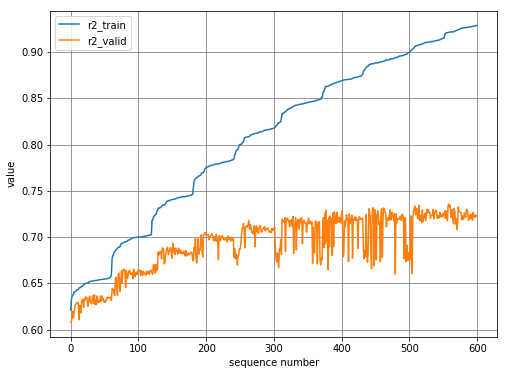

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.plot( [i for i in range(len(result_df.r2_train))], result_df.r2_train)
ax.plot( [i for i in range(len(result_df.r2_train))], result_df.r2_valid)
ax.grid(which='major', color='grey')
ax.grid(which='minor', color='k')
plt.xlabel('sequence number' )
plt.ylabel('value')
plt.legend(('r2_train', 'r2_valid'))

Данные test скорректированы в отдельном файле

In [55]:
correct_test = pd.read_csv('correct_test.csv')
correct_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,...,1,NaN,0,0,0,1,0,1,0,1
1,15856,74,2.0,69.263183,69.263183,1.0,1.0,1.0,1977,0.075779,...,3,NaN,0,2,0,1,0,1,0,1
2,5480,190,1.0,15.948246,15.948246,12.0,2.0,5.0,1909,0.000000,...,87,4702.0,5,5,0,1,0,1,0,1
3,15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,...,3,NaN,3,3,0,1,0,1,0,1
4,14275,27,1.0,47.527111,43.387569,1.0,17.0,17.0,2017,0.072158,...,1,NaN,0,0,0,1,0,1,1,0


In [56]:
correct_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null float64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Ecology_2_A      5000 non-null int64
Ecology_2_B      5000 non-null int64
Ecology_3_A      5000 non-null int64
Ecology_3_B      5000 non-null int64
Shops_2_A        5000 non-null int64
Shops_2_B        5000 non-null int64
dtypes: float64(8), int64(14)
memory usage: 859.5 KB


Предсказание на тестовых данных делаем на основании модели из второго варианта

In [60]:
fts = ['Square', 'Rooms', 'LifeSquare','HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'KitchenSquare' ]
pred_result = recommended_model.predict(correct_test.loc[:, fts])
correct_test['Price'] = pred_result

In [61]:
correct_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,...,NaN,0,0,0,1,0,1,0,1,155151.689997
1,15856,74,2.0,69.263183,69.263183,1.0,1.0,1.0,1977,0.075779,...,NaN,0,2,0,1,0,1,0,1,211692.416536
2,5480,190,1.0,15.948246,15.948246,12.0,2.0,5.0,1909,0.000000,...,4702.0,5,5,0,1,0,1,0,1,229748.846768
3,15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,...,NaN,3,3,0,1,0,1,0,1,318854.405681
4,14275,27,1.0,47.527111,43.387569,1.0,17.0,17.0,2017,0.072158,...,NaN,0,0,0,1,0,1,1,0,130638.356060


In [62]:
correct_test.loc[:, ['Id', 'Price']].to_csv('my_predictions.csv', index=None)

В файл не включены варианты разработки, которые не дали улучшения качества модели